# Задание

Построить нейронную сеть по архитектуре ***Encoder – Decoder***, что должна переводить токсичные комменты в нетоксичные (***Paraphrasing***/***Translation***).
* В архитектуре сети обязательно использование слоя эмбеддинга и LSTM (реализация с помощью ***Keras***).

# Настройки/Импорты

Версии важных модулей:
* pandas==2.1.1
* numpy==1.26.2
* keras==3.3.3
* tensorflow==2.16.1 (no GPU)
* matplotlib==3.6.2
* navec==0.10.0

In [1]:
import numpy as np # для работы с массивами
import pandas as pd # для удобной работы с датасетом

import re # для регулярных выражений

from nltk.tokenize import word_tokenize # для токенизации строк
from tensorflow.keras.preprocessing.text import Tokenizer # токенизатор текста (на версии keras 2.15.0 можно было не тягать из tensorflow)
from keras.utils import pad_sequences # для приведения векторов токенов к единой размерности
from navec import Navec # для русскоязычных эмбеддингов

from keras.layers import Input, Dense, Embedding, LSTM # слои для нейронной сети
from keras.models import Model # Keras модель (не последовательная)
from keras.callbacks import ModelCheckpoint, EarlyStopping # callback функции
import keras # для работы с моделью

import matplotlib.pyplot as plt # для построения графиков
import time # для отслеживания времени выполнения

In [2]:
DATA_DIR = "./data/" # путь до папки с данными
EMBEDDING_DIR = "./embeddings/" # путь до папки с эмбеддингами
MODELS_DIR = "./models/" # путь до папки с моделями
RANDOM_STATE = 42 # число для задания случайности
DTYPE = np.float32 # используемый тип

MAX_WORDS_TOKENIZER = None # ограничение на число слов в словаре токенизатора (None — без ограничения)
MAX_LEN = 39 # оптимальное число токенов в документе (если не достаёт — padding, если перебор — truncation), определялось по гистограмме распределения числа токенов в текстах
ENCODING_DIM = 256  # итоговая размерность пространства, в которое будет преобразован выход энкодера (такая же размерность входа у декодера)
EMBEDDING_DIM = 300 # размерность вектора-эмбеддинга слова

EPOCHS_PATIENCE = 50 # число эпох без изменения наблюдаемой метрики, после которого обучение прекратится
EPOCHS = 300 # число эпох обучения
LEARNING_RATE = 0.001 # learning rate
BATCH_SIZE = 10 # размер батча (число сэмплов, передаваемых в модель одновременно => чем больше значение - тем быстрее обучение, но хуже качество из-за аккумуляции градиентов)

# Предобработка датасета

In [3]:
dataset = pd.read_excel(DATA_DIR + "dataset_200.xls", index_col=None) # считывание excel данных (index_col — какой столбец из данных использовать как индексы в DataFrame)
dataset

,Toxic comment,Polite comment
0,"почитай посты у этого автора, дебил.","попробуйте почитать посты этого автора, может ..."
1,"мне жаль тебя, гандон, если для тебя оскорблен...","извините, но мне вас очень жаль, если для вас ..."
2,"тебе в говне ходить нормально, урод?","извини, но приятно бы тебе было ходить в грязном?"
3,"блять, я согласен, что энергия от виэ на текущ...","я согласен с вами, что энергия от виэ на текущ..."
4,я этим сраным ватсаппом никогда не пользовался...,"просто я, к сожалению, ватсаппом никогда не по..."
...,...,...
194,Пошел нахуй с тупичка,Уходите с тупичка
195,"Да уж, ебаные татары русское население мягко г...","Да уж, татары русское население мягко говоря н..."
196,Умный дурак в два раза опасней,Умный глупец в два раза опасней
197,Это беседа одного того самого имбецила?,Это беседа одного того самого человека?


## Токенизация

Добавление токенов старта и конца.

In [4]:
dataset["Toxic comment"] = dataset["Toxic comment"].apply(lambda text: word_tokenize(text)) # разбиваем текст на слова (токены)
dataset["Toxic comment"] = dataset["Toxic comment"].apply(lambda sequence: ["<start>"] + sequence + ["<end>"]) # добавление токенов старта (<start>) и конца (<end>)
dataset["Toxic comment"] = dataset["Toxic comment"].apply(lambda sequence: " ".join(sequence)) # собираем последовательность слов обратно в строку, но теперь даже служебные символы разделены пробелами

dataset["Polite comment"] = dataset["Polite comment"].apply(lambda text: word_tokenize(text)) # разбиваем текст на слова (токены)
dataset["Polite comment"] = dataset["Polite comment"].apply(lambda sequence: ["<start>"] + sequence + ["<end>"]) # добавление токенов старта (<start>) и конца (<end>)
dataset["Polite comment"] = dataset["Polite comment"].apply(lambda sequence: " ".join(sequence)) # собираем последовательность слов обратно в строку, но теперь даже служебные символы разделены пробелами

texts = dataset["Toxic comment"].tolist() + dataset["Polite comment"].tolist() # собираем все текста в один список
texts[:5] # пример первых пяти получившихся элементов

['<start> почитай посты у этого автора , дебил . <end>',
 '<start> мне жаль тебя , гандон , если для тебя оскорбления - норма . <end>',
 '<start> тебе в говне ходить нормально , урод ? <end>',
 '<start> блять , я согласен , что энергия от виэ на текущий момент дороже . но объясните мне , нахуя правительства всех стран мира стараются развить эту ебанину ? ! нахрена развивать нечто , заведомо убыточное ? ! <end>',
 '<start> я этим сраным ватсаппом никогда не пользовался , а теперь придется ставить ради одного дебильного турнира . пиздец <end>']

Конвертация строк (документов) в последовательности токенов.

In [5]:
tokenizer = Tokenizer(num_words=MAX_WORDS_TOKENIZER, filters='', lower=True, split=" ", char_level=False, oov_token='<OOV>') # создаём объект токенизатора, без ограничения числа токенов (num_words=None)
tokenizer.fit_on_texts(texts) # обучаем токенизатор на текстах

In [6]:
word2id = tokenizer.word_index # словарь соответствия слова его id_шнику (не ограничены MAX_FEATURES)
id2word = tokenizer.index_word # словарь соответствия id_шника слову (не ограничены MAX_FEATURES)

vocab_size = len(id2word) # число слов в корпусе
docs_count = len(dataset) # число документов в корпусе

print(f"Число уникальных слов в корпусе: {vocab_size}.") # включая специальные токены
list(word2id.items())[:10] # первые 10 элементов словаря конвертации слова в токен (id)

Число уникальных слов в корпусе: 1316.


[('<OOV>', 1),
 (',', 2),
 ('<start>', 3),
 ('<end>', 4),
 ('.', 5),
 ('?', 6),
 ('не', 7),
 ('и', 8),
 ('что', 9),
 ('в', 10)]

In [7]:
encoded_toxic = tokenizer.texts_to_sequences(dataset["Toxic comment"]) # токенизируем документы
encoded_polite = tokenizer.texts_to_sequences(dataset["Polite comment"]) # токенизируем документы

print(f"Пример токенизации документа: {encoded_polite[0]}.") # пример токенизации первого документа

Пример токенизации документа: [3, 197, 1134, 60, 56, 256, 2, 78, 238, 38, 1135, 1136, 117, 215, 1137, 5, 113, 2, 16, 1138, 1139, 31, 4].


Пример получившегося преобразования в токены:

In [8]:
for token in encoded_polite[0]: # идём по токенам примера 0
    print(f"{token} — {id2word[token]}") # выводим токен (id) и соответствующее ему слово

3 — <start>
197 — попробуйте
1134 — почитать
60 — посты
56 — этого
256 — автора
2 — ,
78 — может
238 — быть
38 — вам
1135 — удастся
1136 — найти
117 — там
215 — что-то
1137 — полезное
5 — .
113 — надеюсь
2 — ,
16 — я
1138 — смог
1139 — помочь
31 — )
4 — <end>


Приведение последовательностей токенов к одной длине (размерности).

In [9]:
lengths = [] # список под длины документов в токенах
for doc in encoded_toxic + encoded_polite: # идём по токенизированным документам
    lengths.append(len(doc)) # добавляем число токенов в документе в список

print(f"Максимальная длина документа в токенах: {max(lengths)}.")

Максимальная длина документа в токенах: 39.


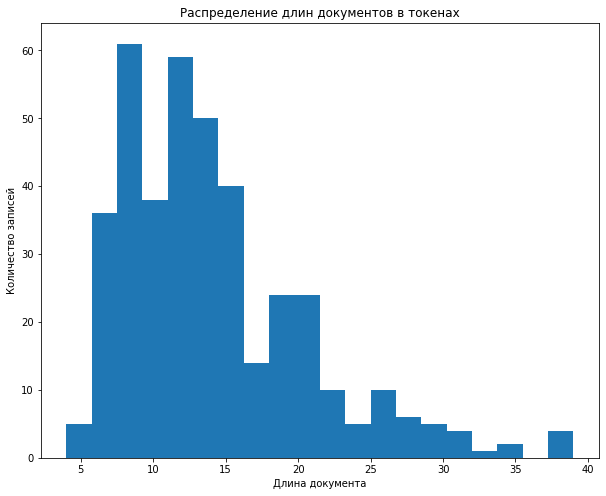

In [10]:
plt.figure(figsize=(10,8)) # задание размера фигуры
plt.hist(lengths, bins=20) # построение столбчатой диаграммы по данным
plt.title("Распределение длин документов в токенах") # название фигуры
plt.xlabel("Длина документа") # подпись по оси x
plt.ylabel("Количество записей") # подпись по оси y
plt.show() # показ фигуры

In [11]:
padded_toxic = pad_sequences(encoded_toxic, maxlen=MAX_LEN, padding="post", truncating="post", value=0) # приводим вектора токенов к единой размерности MAX_LEN с помощью padding_а и truncating_а (заполняем значением value)
padded_polite = pad_sequences(encoded_polite, maxlen=MAX_LEN, padding="post", truncating="post", value=0) # приводим вектора токенов к единой размерности MAX_LEN с помощью padding_а и truncating_а (заполняем значением value)

print(f"Финальная размерность токенизированных документов: сэмплов — {padded_polite.shape[0]}, токенов — {padded_polite.shape[1]}.")
padded_polite

Финальная размерность токенизированных документов: сэмплов — 199, токенов — 39.


array([[   3,  197, 1134, ...,    0,    0,    0],
       [   3,  198,    2, ...,    0,    0,    0],
       [   3,  216,    2, ...,    0,    0,    0],
       ...,
       [   3,  844, 1314, ...,    0,    0,    0],
       [   3,   23,  848, ...,    0,    0,    0],
       [   3,   27,    8, ...,    0,    0,    0]])

In [12]:
id2word[0] = "<pad>" # добавление токена пропуска (<pad>) под индексом 0
word2id["<pad>"] = 0 # добавление токена пропуска (<pad>) под индексом 0
vocab_size += 1 # увеличение размера словаря под токен паддинга (идёт под индексом 0)

## Подготовка данных для обучения

In [13]:
target_data = np.zeros(shape=(docs_count, MAX_LEN, vocab_size), dtype=DTYPE) # трёхмерный массив размерности (число документов, число токенов в документе, размер словаря) — таргеты (вероятности слова-токена word_id, что является t-ым токеном в d-м документе)
for d, doc_tokenized in enumerate(padded_polite): # идём по документам в корпусе
    for t, word_id in enumerate(doc_tokenized[1:]): # идём по токенам в документе (пропуская первый, <start>, так как он и так будет предоставлен)
        if word_id > 0: # если токен не нулевой (паддинга)
            target_data[d][t][word_id] = 1 # ставим ему вероятность = 1 (у всех остальных будут нулю на размерности, отвечающей за vocab_size)
            # у всех токенов, что имеют значение паддинга, вероятности будут равные нулю (чтобы в них вообще ничего не предсказывалось)

In [14]:
target_data # вероятности слов на каждой позиции токена в документах

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

Пример разницы входа у декодера и ожидаемого выхода (argmax по вероятностям слов).

In [15]:
padded_polite[0]

array([   3,  197, 1134,   60,   56,  256,    2,   78,  238,   38, 1135,
       1136,  117,  215, 1137,    5,  113,    2,   16, 1138, 1139,   31,
          4,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])

In [16]:
np.argmax(target_data[0], axis=1) # пример таргетов (axis=1 - по столбцам, то есть вероятностям слов на позиции токена t)

array([ 197, 1134,   60,   56,  256,    2,   78,  238,   38, 1135, 1136,
        117,  215, 1137,    5,  113,    2,   16, 1138, 1139,   31,    4,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int64)

## Эмбеддинги

Для получения векторов-эмбеддингов воспользуемся [***Navec***](https://github.com/natasha/navec?tab=readme-ov-file), так как он компактный (легко умещается в память оперативную/физическую), хоть и имеет огромный словарь, и заточен под работу с русским языком. Словарь Navec содержит 500000 слов, представленных в виде векторов размерности 300.

In [17]:
navec = Navec.load(f"{EMBEDDING_DIR}navec_hudlit_v1_12B_500K_300d_100q.tar") # загружаем вектора
# navec_hudlit_v1_12B_500K_300d_100q.tar
#                  |    |    |    |
#                  |    |    |     ---- 100 dimentions after quantization
#                  |    |     --------- original vectors have 300 dimentions
#                  |     -------------- vocab size is 500 000 words + 2 for <unk>, <pad>
#                   ------------------- dataset of 12 billion tokens was used

In [18]:
navec.get("россия") # пример работы Navec (возвращает np.array типа float32)

array([ 0.22543699, -0.39721358,  0.6805563 ,  0.21706595, -0.19716908,
       -0.20722607, -0.07350219,  0.13129961, -0.17141329,  0.09088685,
        0.21599719, -0.09282316,  0.00766279, -0.11043157, -0.07346303,
        0.42286018, -0.26629096,  0.31371886, -0.08937341,  0.09485467,
       -0.04480258, -0.44643393, -0.3061798 , -0.2882515 ,  0.5377174 ,
        0.36234093,  0.0030303 ,  0.23453966, -0.28672412, -0.20668298,
       -0.19193137,  0.04902396,  0.8125157 ,  0.5318507 , -0.6188356 ,
       -0.04572238, -0.02173791, -0.66719943, -0.7230108 , -0.2762196 ,
       -0.23562106,  0.5413357 , -0.05294172,  0.6201654 , -0.8374897 ,
       -0.36382714,  0.4649254 , -0.13510832,  0.09727751, -0.10602053,
        0.37899598, -0.36541265, -0.20060915,  0.10681065, -0.5519943 ,
       -0.13753682, -0.01502502,  0.09474958, -0.05980838, -0.02857767,
       -0.55855787, -0.04823827, -0.3578416 ,  0.88438463,  0.32023084,
       -0.25467572,  0.22748815, -0.6873215 , -0.04857488, -0.74

Заполняем матрицу эмбеддингов векторами, соответствующими словам (или нулями, если слова нет в словаре Navec, они позже будут дообучены в модели).

In [19]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM)) # создаём матрицу из нулей под эмбеддинги слов (+1 — для вектора паддинга, что будет идти под индексом 0)

skipped_words = [] # список под слова без вектора
for i in range(1, vocab_size): # идём по числу слов (токенов), начиная с 1, так как 0 под padding и до vocab_size не включительно (чтобы уместить все слова)
    word = id2word[i] # слово, что идёт под номером i в токенизаторе
    if navec.get(word) is not None: # если у рассматриваемого слова есть вектор в Navec (иначе вернёт None)
        embedding_matrix[i] = navec.get(word) # записываем i-ый вектор в матрицу эмбеддингов
    else: # если слова нет в Navec
        skipped_words.append(word) # добавляем слово в список пропущенных

print(f"Пропущенно {len(skipped_words)} слов из {vocab_size}.")

Пропущенно 170 слов из 1317.


# Работа с моделью

![seq2seq model](images/seq2seq.png)

## Основная структура модели

In [20]:
# энкодер (на вход идут токсичные сообщения)
encoder_input = Input(shape=(MAX_LEN,), dtype=DTYPE, name='encoder_input') # входной слой энкодера, получает вектор размера (BATCH_SIZE, число слов или токенов в входных данных)
encoder_embedding = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, name='encoder_embedding')(encoder_input) # слой эмбеддинга (на вход — encoder_input размера словаря input_dim, выход размерности (BATCH_SIZE, число токенов в документе, размерность вектора-эмбеддинга))
encoder_output, encoder_hidden_state, encoder_context = LSTM(units=ENCODING_DIM, return_state=True, name='encoder_lstm')(encoder_embedding) # слой LSTM, return_state — возвращающий помимо выхода слоя, также свой hidden_state и вектор context_а
encoder_state = [encoder_hidden_state, encoder_context] # запоминаем hidden_state и вектор context_а энкодера (пойдут как начальное состояние декодера)
# РАБОТА С ВЫХОДОМ ЭНКОДЕРА БОЛЬШЕ НЕ ВЕДЁТСЯ, А ТОЛЬКО С ЕГО СОСТОЯНИЕМ ПРИ ВЫХОДЕ

# декодер (на вход идут нетоксичные сообщения)
decoder_input = Input(shape=(MAX_LEN,), dtype=DTYPE, name='decoder_input') # входной слой декодера, получает вектор размера (BATCH_SIZE, число слов или токенов в выходных данных)
decoder_embedding_layer = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, name='decoder_embedding') # слой эмбеддинга (на вход — decoder_input размера словаря input_dim, выход размерности (BATCH_SIZE, число токенов в документе, размерность вектора-эмбеддинга))
decoder_embedding = decoder_embedding_layer(decoder_input) # вызов слоя эмбеддинга
decoder_lstm_layer = LSTM(units=ENCODING_DIM, return_sequences=True, return_state=True, name='decoder_lstm') # слой LSTM, return_state — возвращающий помимо выхода слоя, также свой hidden_state и вектор context_а; return_sequences — возвращать лишь последний выход или выходы для всй входной последовательности (True - чтобы предсказывать целую последовательность, иначе было бы лишь одно число)
decoder_lstm, _, _ = decoder_lstm_layer(decoder_embedding, initial_state=encoder_state) # вызываем слой LSTM с передачей внутреннего состояния из энкодера
decoder_dense = Dense(units=vocab_size, activation="softmax", name='word_probs') # линейный слой с "softmax" для получения вероятностей слов (units=vocab_size) на позиции токена t, а так как LSTM возвращает последовательность (return_sequences=True) - выходом будет трёхмерная матрица (BATCH_SIZE, число токенов в документе, размер словаря)
decoder_output = decoder_dense(decoder_lstm) # вызываем линейный слой

# общая модель
model = Model(inputs=[encoder_input, decoder_input], outputs=decoder_output) # финальное объединение в одну модель

model.summary() # вывод данных о модели

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 39)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, 39)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 39, 300)   │    395,100 │ encoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 39, 300)   │    395,100 │ decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 256),     │    570,368 │ encoder_embeddin… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 39, 256), │    570,368 │ decoder_embeddin… │
│                     │ (None, 256),      │            │ encoder_lstm[0][… │
│                     │ (None, 256)]      │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ word_probs (Dense)  │ (None, 39, 1317)  │    338,469 │ decoder_lstm[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,269,405 (8.66 MB)

 Trainable params: 2,269,405 (8.66 MB)

 Non-trainable params: 0 (0.00 B)

Устанавливаем специфичные веса и параметры обучения для слоя эмбеддинга.

In [21]:
model.layers

[<InputLayer name=encoder_input, built=True>,
 <InputLayer name=decoder_input, built=True>,
 <Embedding name=encoder_embedding, built=True>,
 <Embedding name=decoder_embedding, built=True>,
 <LSTM name=encoder_lstm, built=True>,
 <LSTM name=decoder_lstm, built=True>,
 <Dense name=word_probs, built=True>]

In [22]:
model.layers[2].set_weights([embedding_matrix]) # устанавливаем вектора эмбеддингов
# model.layers[2].trainable = False # ставим флаг, что слой не будет обучаться
model.layers[3].set_weights([embedding_matrix]) # устанавливаем вектора эмбеддингов
# model.layers[3].trainable = False # ставим флаг, что слой не будет обучаться

## Callback функции

In [23]:
def get_early_stopping():
    """
    This function should return an EarlyStopping callback that stops learning when the
    validation (testing) accuracy has not improved over the last N epochs.
    """
    early_stopping = EarlyStopping(monitor="loss", mode="min", patience=EPOCHS_PATIENCE) # callback ранней остановки обучения
    # monitor — по какой метрике судить, нужно ли прекращать обучение, например - val_loss
    # mode — метрика должна увеличиваться (max) или уменьшаться (min)
    # patience — сколько должно пройти эпох без улучшения отслеживаемой метрики чтобы прекратить обучение
    return early_stopping


def get_checkpoint_best_only():
    """
    This function should return a ModelCheckpoint object that:
    - stores only those weights of the neural network that generate the highest accuracy during testing
    - saves to the 'checkpoints_best_only' directory inside the current working directory
    - generates a file named '{MODELS_DIR}best_model.keras'
    """
    checkpoint_best = ModelCheckpoint(filepath=f"{MODELS_DIR}best_model.keras", save_best_only=True, save_weights_only=False, monitor="loss", mode="min") # callback сохранения чекпоинтов модели
    # filepath — путь до файла, куда сохранять (можно с указанием эпохи...)
    # save_best_only — сохранять только если результат (отслеживаемая метрика) улучшилась
    # save_weights_only — сохранять ли только веса
    # monitor — по какой метрике судить, стала ли модель лучше/хуже
    # mode — метрика должна увеличиваться (max) или уменьшаться (min)
    return checkpoint_best

## Сборка модели с обучением

**Переобучение для моделей генерации и перевода (детоксикации) текста на самом деле положительно сказывается на её ответах.**

In [24]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=None) # компилирование модели с указанием оптимизатора, функции потерь и дополнительных метрик

In [25]:
callback_checkpoint = get_checkpoint_best_only() # callback сохранения чекпоинтов
callback_stopping = get_early_stopping() # callback ранней остановки обучения

callbacks = [callback_checkpoint, callback_stopping] # список callback_ов

In [26]:
time_start = time.time() # замеряем время начала обучения

history = model.fit(x=[padded_toxic, padded_polite], y=target_data, validation_data=None, validation_split=0, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, verbose=1) # запускаем обучение модели (результатом которого будет история изменения метрик)
# x — вход модели (а данном случае — двойной)
# y — таргеты
# epochs — число эпох обучения
# batch_size — размер батчка
# validation_data — тестовые данные (тестовый двойной вход и его таргеты)
# validation_split — если validation_data=None, то validation_split определяет, какой процент данных будет использован для валидации (на нём не будет обучения), например 0.2
# callbacks — список callback функций
# verbose — на сколько подробно выводить информацию об обучении (1 - на каждой эпохе)

print(f"Время, затраченное на обучение: {time.time()  - time_start} секунд.")

Epoch 1/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - loss: 2.1207
Epoch 2/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - loss: 1.8259
Epoch 3/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - loss: 1.8037
Epoch 4/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - loss: 1.8209
Epoch 5/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - loss: 1.8480
Epoch 6/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 1.8735
Epoch 7/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - loss: 1.7337
Epoch 8/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - loss: 1.7351
Epoch 9/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - loss: 1.8391
Epoch 10/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - loss: 1.6975
Epoch 11/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 1.7650
Epoch 12/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 1.7976
Epoch 13/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 1.8479
Epoch 14/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 1.7879
Epoch 15/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 

In [27]:
history_dict = history.history # словарь с историей обучения
print(history_dict.keys()) # ключи в словаре истории

dict_keys(['loss'])


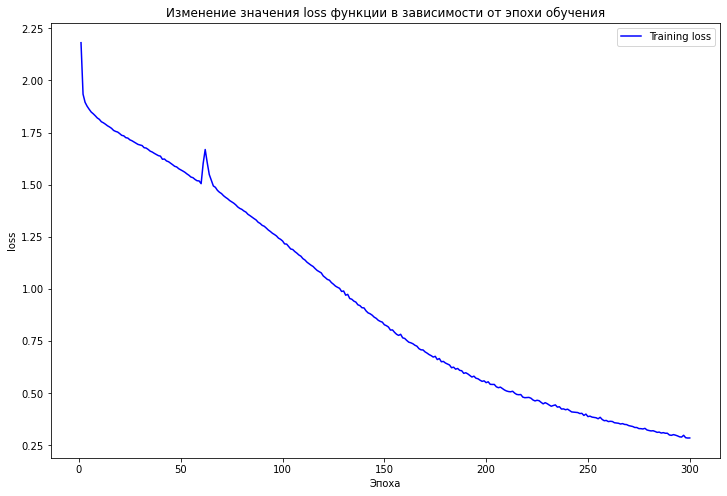

In [28]:
plt.figure(figsize=(12,8)) # задание размера графика
epochs = range(1, len(history_dict['loss']) + 1) # число эпох обучения (сколько было сохранено значений loss)
plt.plot(epochs, history_dict["loss"], 'b', label='Training loss') # построение линейного графика ('b' — синего цвета)
plt.title("Изменение значения loss функции в зависимости от эпохи обучения") # название фигуры
plt.xlabel('Эпоха') # подпись по оси OX
plt.ylabel('loss') # подпись по оси OY
plt.legend() # вывод подписей для графиков
plt.show() # показ фигуры

In [29]:
model.save(f"{MODELS_DIR}final_model.keras") # сохранение модели

# Inference

Загружаем сохранённую модель.

In [30]:
model = keras.models.load_model(f"{MODELS_DIR}best_model.keras") # загружаем сохранённую модель
model.layers

[<InputLayer name=encoder_input, built=True>,
 <InputLayer name=decoder_input, built=True>,
 <Embedding name=encoder_embedding, built=True>,
 <Embedding name=decoder_embedding, built=True>,
 <LSTM name=encoder_lstm, built=True>,
 <LSTM name=decoder_lstm, built=True>,
 <Dense name=word_probs, built=True>]

Так как мы грузим модель извне, то нужно описать входы, выходы и промежуточный вектор.

### Энкодер

In [31]:
encoder_input = model.input[0] # вход энкодера

#=================================== v1 ========================================
# encoder_output, *encoder_state = model.layers[4].output # выход энкодера (из LSTM), hidden_state и context сразу записываем в encoder_state
#----------------------------------- v2 ----------------------------------------
encoder_embedding = model.layers[2](encoder_input) # вызываем слой эмбеддинга энкодера
encoder_output, *encoder_state = model.layers[4](encoder_embedding) # вызываем слой LSTM энкодера, hidden_state и context сразу записываем в encoder_state
#===============================================================================

encoder_model = Model(inputs=encoder_input, outputs=encoder_state) # модель энкодера

In [32]:
encoder_model.layers # получили обратно все слои

[<InputLayer name=encoder_input, built=True>,
 <Embedding name=encoder_embedding, built=True>,
 <LSTM name=encoder_lstm, built=True>]

### Декодер

In [33]:
decoder_input = model.input[1] # вход декодера

decoder_hidden_state = Input(shape=(ENCODING_DIM,), name='decoder_hidden_state') # hidden_state декодера идёт сначала пустым
decoder_context = Input(shape=(ENCODING_DIM,), name='decoder_context') # context вектор декодера идёт сначала пустым
decoder_state_input = [decoder_hidden_state, decoder_context] # запоминаем hidden_state и вектор context_а декодера (пойдут как начальное состояние)

# decoder_embedding = decoder_embedding_layer(decoder_input) # вызываем слой эмбеддинга декодера
decoder_embedding = model.layers[3](decoder_input) # вызываем слой эмбеддинга декодера

# decoder_lstm, *decoder_state = decoder_lstm_layer(decoder_embedding, initial_state=decoder_state_input) # вызываем слой LSTM декодера, hidden_state и context сразу записываем в encoder_state
decoder_lstm, *decoder_state = model.layers[5](decoder_embedding, initial_state=decoder_state_input) # вызываем слой LSTM декодера, hidden_state и context сразу записываем в encoder_state

# decodet_output = decoder_dense(decoder_lstm) # вызываем линейный слой для получения вероятностей слов
decodet_output = model.layers[6](decoder_lstm) # вызываем линейный слой для получения вероятностей слов

decoder_model = Model(inputs=[decoder_input] + decoder_state_input, outputs=[decodet_output] + decoder_state) # модель декодера с нексолькими данными на вход (токены и state) и выход (вероятности слов на позициях и state)

In [34]:
decoder_model.layers # получили обратно все слои

[<InputLayer name=decoder_input, built=True>,
 <Embedding name=decoder_embedding, built=True>,
 <InputLayer name=decoder_hidden_state, built=True>,
 <InputLayer name=decoder_context, built=True>,
 <LSTM name=decoder_lstm, built=True>,
 <Dense name=word_probs, built=True>]

## Детоксикация текста

In [35]:
# процедура декодирования последовательности
def decode_sequence(input_seq) -> str:
    """
    Функция для конвертированя вероятностей токенов на каждой позиции в слова.\n
    Parameters:
        * input_seq: входная последовательность для энкодера (список токенов)\n
    Returns:
        * str: декодированная строка
    """
    state = encoder_model.predict(input_seq) # делаем предсказание по токенам при помощи энкодера и получаем на выходе его state

    # создаём "вектор" таргетов, что пойдёт на вход декодеру, начинается с токена <start> (будет передаваться в модель, пока не сгенерируется токен окончания предсказания)
    target_seq = np.zeros((1, 1)) # создадим пустой вектор, который будет содержать нашу предсказанную последовательнось, размерности (BATCH_SIZE=1, токены таргета)
    target_seq[0, 0] = word2id["<start>"] # первый символ target последовательности будет токен "<start>"

    # проводим процедуру генерации токенов
    stop_condition = False # ключ для выхода генерации перевода
    decoded_sentence = "" # строка получившегося перевода
    decoded_counter = 0 # счётчик числа декодированных токенов
    while not stop_condition: # пока не выполнено условие прекращения генерации
        # генерируем текущий токен на основе пока пустой target последовательности (в ней только токен <start>) и state из энкодера
        # процес повторяется, шаг за шагом, в ходе итерауий модель генерируем последовальность токенов
        output_tokens, *state = decoder_model.predict([target_seq] + state) # декодируем последовательность с учётом внутреннего состояния

        pred_token = np.argmax(output_tokens[0, -1, :]) # определяем id самого вероятного токена (0 — так как BATCH_SIZE=1 при инференсе, -1 — токен на последней сгенерированной позиции, : — среди всех вероятности слов)        
        pred_word = id2word[pred_token] # определяем слово на основе его id (токена)
        target_seq[0, 0] = pred_token # обновляем target за счет нового токена для следующего шага (всегда будет состоять из последнего полученного токена, так как декодер ожидает на вход только один токен, помимо state)

        if pred_word in ["<end>", "<pad>"] or decoded_counter >= MAX_LEN: # условие остановки — достижение максимальной длины (числа токенов), либо найдены токены <end> или <pad>
            stop_condition = True # меняем флаг прекращения генерации токенов
        else:
            decoded_sentence += f" {pred_word}" # добавляем слово в конец полученной декодируемой строки с пробелом
            decoded_counter += 1 # обновляем счётчик декодированных токенов в последовательности

    decoded_sentence = re.sub(r'\s+(?=(?:[,.?!:;…]))', r'', decoded_sentence) # удаляем пробелы перед знаками препинания
    return decoded_sentence.strip() # возвращаем строку без пробелов

In [38]:
text = "Ты дебил хоть читать умеешь или совсем уже отупел?" # приходящий текст
print(f"Токсичный текст: {text}")

sequence = word_tokenize(text) # разбиваем текст на слова (токены)
sequence = ["<start>"] + sequence + ["<end>"] # добавление токенов старта (<start>) и конца (<end>)
text = " ".join(sequence) # собираем последовательность слов обратно в строку, но теперь даже служебные символы разделены пробелами
encoded_text = tokenizer.texts_to_sequences([text]) # токенизируем текст
padded_text = pad_sequences(encoded_text, maxlen=MAX_LEN, padding="post", truncating="post", value=0) # приводим вектора токенов к единой размерности MAX_LEN с помощью padding_а и truncating_а (заполняем значением value)

decoded_sentence = decode_sequence(padded_text)
print(f"Обработанный текст: {decoded_sentence}")

Токсичный текст: Ты дебил хоть читать умеешь или совсем уже отупел?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Обработанный текст: вы, дорогой, просто не умеете читать между строк.


In [39]:
for token in padded_text[0]: # идём по токенам
    print(f"{token} — {id2word[token]}") # выводим токен (id) и соответствующее ему слово

3 — <start>
11 — ты
105 — дебил
177 — хоть
157 — читать
375 — умеешь
47 — или
103 — совсем
149 — уже
1 — <OOV>
6 — ?
4 — <end>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
0 — <pad>
